In [ ]:
from himalaya.ridge import RidgeCV
import numpy as np
from pathlib import Path
from AOTaccess.stimulus_info_access import StimuliInfoAccess
from AOTaccess.glmsingle_access import GLMSingleAccess

from himalaya.backend import set_backend

backend = set_backend("torch_cuda", on_error="warn")

from AOTanalysis.bandedRR.utils import (
    reshape_from_flatten_masked_to_wholebrain,
)
from AOTanalysis.voxelsemantic.corpus_construct import construct_AOT_corpus
import joblib
import pickle
from pprint import pprint

import matplotlib.pyplot as plt
import random
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from nibabel import Nifti1Image
import cortex
import nibabel as nib


from matplotlib.colors import Normalize
def Vertex2D_fix(data1, data2, subject, cmap, vmin, vmax, vmin2, vmax2, roi_borders=None):
    #this provides a nice workaround for pycortex opacity issues, at the cost of interactivity    
    # Get curvature
    curv = cortex.db.get_surfinfo(subject)
    # Adjust curvature contrast / color
    curv.data = curv.data * .75 +0.1
    curv = cortex.Vertex(curv.data, subject, vmin=-1,vmax=1,cmap='gray')
    norm2 = Normalize(vmin2, vmax2)   
    vx = cortex.Vertex(data1, subject, cmap=cmap, vmin=vmin, vmax=vmax)
    # Map to RGB
    vx_rgb = np.vstack([vx.raw.red.data, vx.raw.green.data, vx.raw.blue.data])
    curv_rgb = np.vstack([curv.raw.red.data, curv.raw.green.data, curv.raw.blue.data])
    # Alpha mask
    alpha = np.clip(norm2(data2), 0, 1)
    display_data = (curv_rgb * (1-alpha)) + vx_rgb * alpha
    display_data /= 255
    if roi_borders is not None:
        display_data[:,roi_borders.astype('bool')] = 0
    
    # Create vertex RGB object out of R, G, B channels
    return cortex.VertexRGB(*display_data, subject) 

from AOTanalysis.voxelmotion.filter_info import FilterInfo

backend = set_backend("numpy", on_error="warn")

In [15]:
sub = 3
#model_path = f"/tank/shared/2024/visual/AOT/temp/bandedRR_split_single_feature_withSTD_session_testinside/model_sub{sub}_feature_motion32_trainses_1_Xcentered_True_Yzscore_True_Xstd_True_testinside.joblib"
model_path = f"/tank/shared/2024/visual/AOT/temp/bandedRR_split_single_feature_withSTD_multiple_session_based/model_sub{sub}_feature_motion_trainses_1_2_3.joblib"
model = joblib.load(model_path)

In [16]:
# Load the R2 scores for masking
R2_file = f"/tank/shared/2024/visual/AOT/temp/bandedRR_split_single_feature_withSTD_multiple_session_based/R2_score_single_sub{sub}_motion_train_1_2_3_test_4.nii.gz"
R2 = nib.load(R2_file)
R2_data = R2.get_fdata()
print("R2_data shape:", R2_data.shape)
R2_data = np.transpose(R2_data, (2, 1, 0))
print("Transposed R2_data shape:", R2_data.shape)


R2_data shape: (84, 95, 106)
Transposed R2_data shape: (106, 95, 84)


In [17]:
primal_coef = model[-1].get_primal_coef()
primal_coef = backend.to_numpy(primal_coef)
print("n_features, n_voxels) =", primal_coef.shape)

max_index = np.argmax(primal_coef, axis=0)
print("max_index.shape =", max_index.shape)

n_features, n_voxels) = torch.Size([11845, 352914])
max_index.shape = torch.Size([352914])


In [18]:
filter_info = FilterInfo()

# Calculate speed for each voxel based on the max index
speeds = np.zeros(max_index.shape)
for i in range(max_index.shape[0]):
    speeds[i] = filter_info.velocity_from_index(max_index[i])
print("Speeds shape:", speeds.shape)

# Reshape the speeds into a volume
speeds_volume = reshape_from_flatten_masked_to_wholebrain(speeds, sub=sub)
print("Speeds volume shape:", speeds_volume.shape)

# Transpose the volume to match the expected shape (106, 95, 84)
speeds_volume = np.transpose(speeds_volume, (2, 1, 0))
print("Transposed speeds volume shape:", speeds_volume.shape)


# Create directory for saving results
save_path = Path(f"/tank/shared/2024/visual/AOT/temp/motion_energy_analysis/motion2speed_maxindex")
save_path.mkdir(parents=True, exist_ok=True)

# Get affine and header information for saving nifti files
glminfo = GLMSingleAccess()
affine = glminfo.read_affine(sub)
header = glminfo.read_header(sub)

# Save the speeds to a nifti file
nifti_img = Nifti1Image(speeds_volume, affine=affine, header=header)
nifti_img.to_filename(save_path / f"speeds_sub{sub}.nii.gz")

/tank/zhangs/AOT_code_repos/AOT_analysis/AOTanalysis/voxelmotion/filter_info.py:88: RuntimeWarning: divide by zero encountered in scalar divide
  return temporal_freq / spatial_freq
/tank/zhangs/AOT_code_repos/AOT_analysis/AOTanalysis/voxelmotion/filter_info.py:88: RuntimeWarning: invalid value encountered in scalar divide
  return temporal_freq / spatial_freq


Speeds shape: (352914,)
Speeds volume shape: (84, 95, 106)
Transposed speeds volume shape: (106, 95, 84)


In [19]:
# Investigate the source of infinite values
# Find indices where speeds contain inf or NaN values
invalid_indices = np.where(~np.isfinite(speeds))[0]
if len(invalid_indices) > 0:
    print(f"Found {len(invalid_indices)} invalid speed values")
    # Sample some problematic indices
    sample_size = min(10, len(invalid_indices))
    sample_indices = invalid_indices[:sample_size]
    
    # Check what max_index values lead to infinite speeds
    for idx in sample_indices:
        print(f"Index {idx}: max_index = {max_index[idx]}, speed = {speeds[idx]}")
        
    # Check the distribution of max_index values that cause problems
    problem_indices = max_index[invalid_indices]
    print(f"Unique max_index values causing infinite speeds: {np.unique(problem_indices)}")
    
    # Try to understand the FilterInfo implementation
    print("\nSample of velocity_from_index outputs for different indices:")
    test_indices = np.arange(0, 32, 3)  # Test a sample of indices
    for idx in test_indices:
        print(f"Index {idx} → Speed {filter_info.velocity_from_index(idx)}")
else:
    print("No infinite or NaN values found in speeds array.")

Found 20365 invalid speed values
Index 29: max_index = 3541, speed = inf
Index 30: max_index = 3823, speed = inf
Index 36: max_index = 4471, speed = inf
Index 58: max_index = 3769, speed = inf
Index 67: max_index = 4107, speed = inf
Index 111: max_index = 4203, speed = inf
Index 117: max_index = 3491, speed = nan
Index 127: max_index = 3793, speed = inf
Index 131: max_index = 4309, speed = inf
Index 172: max_index = 680, speed = inf
Unique max_index values causing infinite speeds: [   1    3    5 ... 4955 4957 4959]

Sample of velocity_from_index outputs for different indices:
Index 0 → Speed 0.0
Index 3 → Speed inf
Index 6 → Speed 0.0
Index 9 → Speed 0.0
Index 12 → Speed 0.0
Index 15 → Speed 1.0
Index 18 → Speed 2.0
Index 21 → Speed 1.0
Index 24 → Speed nan
Index 27 → Speed 1.0
Index 30 → Speed nan


Testing safer velocity calculation:
Original index 3541: Original method = inf, Safe method = nan
Original index 3823: Original method = inf, Safe method = nan
Original index 4471: Original method = inf, Safe method = nan
Original index 3769: Original method = inf, Safe method = nan
Original index 4107: Original method = inf, Safe method = nan

After using safer method:
Number of NaN values in safer_speeds: 20365
Number of infinite values in safer_speeds: 0
Min safe speed value: 0.0
Max safe speed value: 2.0


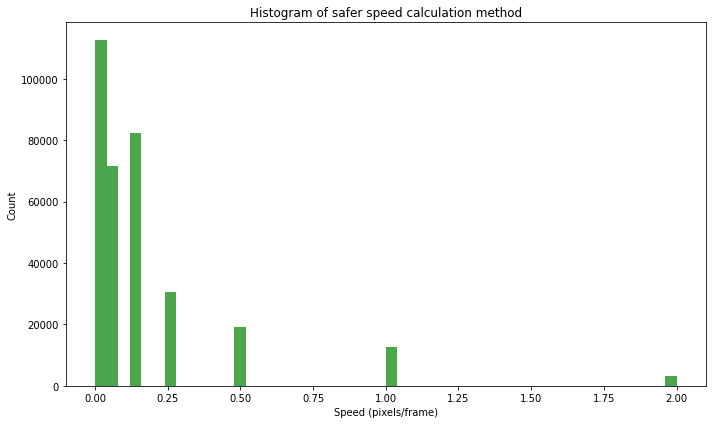

In [20]:
# Define a safer version of velocity_from_index
def safe_velocity_from_index(index_value):
    """
    A safer version of velocity_from_index that returns NaN for any index that would
    produce an infinite or invalid speed value.
    
    Parameters:
    -----------
    index_value : int
        The index value from which to compute the velocity
        
    Returns:
    --------
    float
        The velocity/speed value, or NaN if the computation would result in an infinite value
    """
    try:
        speed = filter_info.velocity_from_index(index_value)
        if not np.isfinite(speed):
            return np.nan
        return speed
    except Exception as e:
        print(f"Error processing index {index_value}: {e}")
        return np.nan

# Test the safer function with our problematic indices
if 'invalid_indices' in locals() and len(invalid_indices) > 0:
    sample_size = min(5, len(invalid_indices))
    sample_indices = invalid_indices[:sample_size]
    
    print("Testing safer velocity calculation:")
    for idx in sample_indices:
        orig_idx = max_index[idx]
        print(f"Original index {orig_idx}: Original method = {speeds[idx]}, Safe method = {safe_velocity_from_index(orig_idx)}")
    
    # Apply the safer method to recalculate speeds
    safer_speeds = np.zeros(max_index.shape)
    for i in range(max_index.shape[0]):
        safer_speeds[i] = safe_velocity_from_index(max_index[i])
    
    print(f"\nAfter using safer method:")
    print(f"Number of NaN values in safer_speeds: {np.sum(np.isnan(safer_speeds))}")
    print(f"Number of infinite values in safer_speeds: {np.sum(np.isinf(safer_speeds))}")
    
    # Check if the safe method makes a difference
    valid_speeds = ~np.isnan(safer_speeds) & np.isfinite(safer_speeds)
    if np.sum(valid_speeds) > 0:
        print(f"Min safe speed value: {np.min(safer_speeds[valid_speeds])}")
        print(f"Max safe speed value: {np.max(safer_speeds[valid_speeds])}")
        
        # Plot histogram of safe speeds for comparison
        plt.figure(figsize=(10, 6))
        plt.hist(safer_speeds[valid_speeds], bins=50, color='green', alpha=0.7)
        plt.xlabel('Speed (pixels/frame)')
        plt.ylabel('Count')
        plt.title('Histogram of safer speed calculation method')
        plt.tight_layout()
        plt.show()

Caching mapper...
Caching mapper...
Full speed range: 0.0 to 2.0
Speed range after excluding outliers (1th-99th percentiles): 0.0 to 2.0


/tank/zhangs/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


Unable to init server: Could not connect: Connection refused
** (inkscape:3084438): WARNING **: 09:42:57.119: Fonts dir '/tank/zhangs/.config/inkscape/fonts' does not exist and will be ignored.
Background RRGGBBAA: ffffff00
Area 0:0:1878.27:1024 exported to 1878 x 1024 pixels (96 dpi)
Unable to init server: Could not connect: Connection refused
** (inkscape:3084567): WARNING **: 09:42:57.747: Fonts dir '/tank/zhangs/.config/inkscape/fonts' does not exist and will be ignored.
Background RRGGBBAA: ffffff00
Area 0:0:1878.27:1024 exported to 1878 x 1024 pixels (96 dpi)


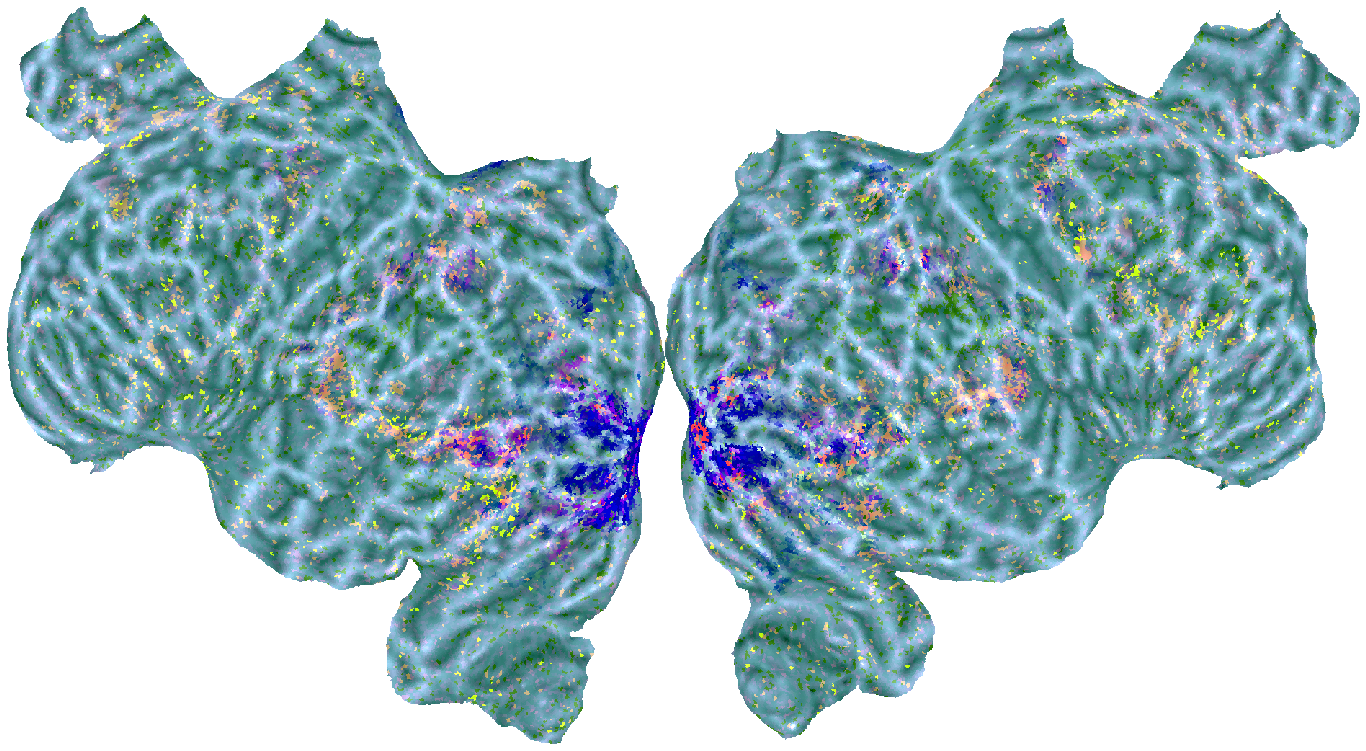

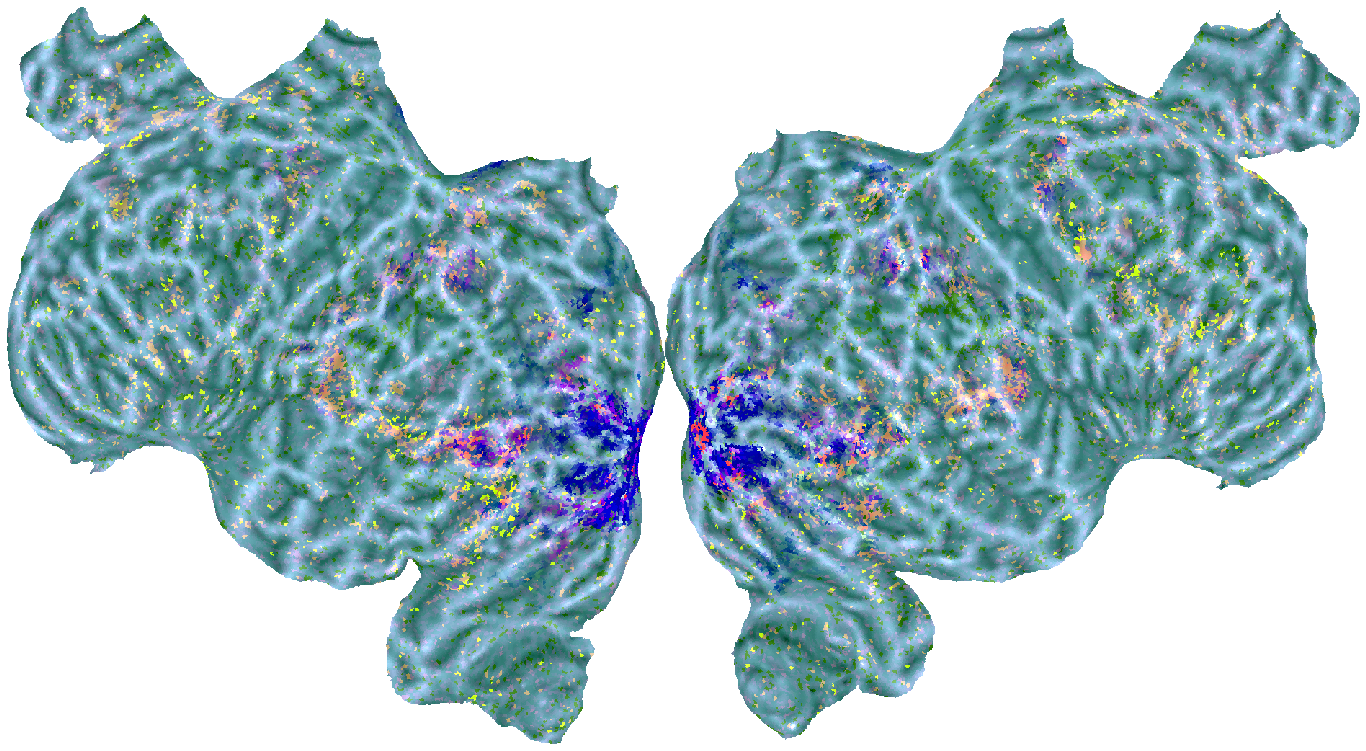

In [21]:
# Visualize the speeds on the cortical surface
sub = "sub-003"

# Handle infinite values in speeds_volume before creating cortex Volume
# Replace infinites and NaNs with a masked value
masked_speeds = speeds_volume.copy()
masked_speeds[~np.isfinite(masked_speeds)] = np.nan  # Replace inf with NaN

# Create cortex volumes for speeds and R2
volume = cortex.Volume(masked_speeds, sub, "AOT1pt7mm", recache=True)
mapper = cortex.get_mapper(sub, "AOT1pt7mm", type="nearest", recache=True)
native_surface_map = mapper(volume)

volume_R2 = cortex.Volume(R2_data, sub, "AOT1pt7mm", recache=True)
mapper_R2 = cortex.get_mapper(sub, "AOT1pt7mm", type="nearest", recache=True)
native_surface_map_R2 = mapper_R2(volume_R2)

# Find max and min speeds for color scaling while excluding outliers
# Using percentiles to exclude extreme values
speed_data = native_surface_map.data[~np.isnan(native_surface_map.data)]
# Also filter out infinites if any remain
speed_data = speed_data[np.isfinite(speed_data)]

lower_percentile = 1  # Exclude bottom 1%
upper_percentile = 99  # Exclude top 1%
min_speed = np.percentile(speed_data, lower_percentile)
max_speed = np.percentile(speed_data, upper_percentile)

# Print both the full range and the range after excluding outliers
full_min = np.nanmin(speed_data)
full_max = np.nanmax(speed_data)
print(f"Full speed range: {full_min} to {full_max}")
print(f"Speed range after excluding outliers ({lower_percentile}th-{upper_percentile}th percentiles): {min_speed} to {max_speed}")

# Create merged map with R2 as opacity
merged_map = Vertex2D_fix(
    native_surface_map.data,
    native_surface_map_R2.data,
    sub,
    cmap="plasma",  # Using plasma colormap for speed
    vmin=min_speed,
    vmax=max_speed,
    vmin2=-0.1,
    vmax2=0.3,  # R2 threshold for opacity
)

# Set colormap for surface map
native_surface_map.cmap = "plasma"

# Display the merged map
cortex.quickshow(
    merged_map,
    with_curvature=False,
    with_colorbar=False,
    with_labels=False,
    with_sulci=True,
    with_legend=False,
    cmap="plasma",
    colorbar_label="Speed (pixels/frame)",
)

In [30]:
# Save native_surface_map
# 'sub' (integer 3) is from cell ade9a816
# 'save_path' is from cell dda9e92b
filename = save_path / f"native_surface_map_MEspeed_{sub}.pkl"
import pickle
with open(filename, "wb") as f:
    pickle.dump(merged_map, f)

In [23]:
# Check for infinite or NaN values in speeds data
print(f"Number of NaN values in speeds: {np.sum(np.isnan(speeds))}")
print(f"Number of infinite values in speeds: {np.sum(np.isinf(speeds))}")
print(f"Min speed value: {np.nanmin(speeds[np.isfinite(speeds)])}")
print(f"Max speed value: {np.nanmax(speeds[np.isfinite(speeds)])}")

# Clean the speeds data by removing infinite and NaN values
speeds_clean = speeds.copy()
# Replace infinites with NaNs first
speeds_clean[~np.isfinite(speeds_clean)] = np.nan
print(f"Percentage of valid data points: {(~np.isnan(speeds_clean)).sum() / speeds_clean.size * 100:.2f}%")

Number of NaN values in speeds: 5040
Number of infinite values in speeds: 15325
Min speed value: 0.0
Max speed value: 2.0
Percentage of valid data points: 94.23%


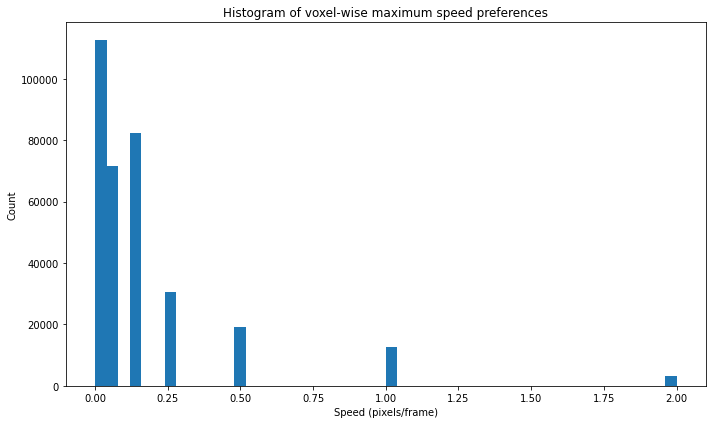

In [24]:
# Create a histogram of the speeds
plt.figure(figsize=(10, 6))
# Use speeds_clean and filter out NaN values
speeds_for_hist = speeds_clean[~np.isnan(speeds_clean)]
plt.hist(speeds_for_hist, bins=50)
plt.xlabel('Speed (pixels/frame)')
plt.ylabel('Count')
plt.title('Histogram of voxel-wise maximum speed preferences')
plt.tight_layout()
plt.savefig(save_path / f"speeds_histogram_sub{sub.replace('sub-', '')}.png")
plt.show()

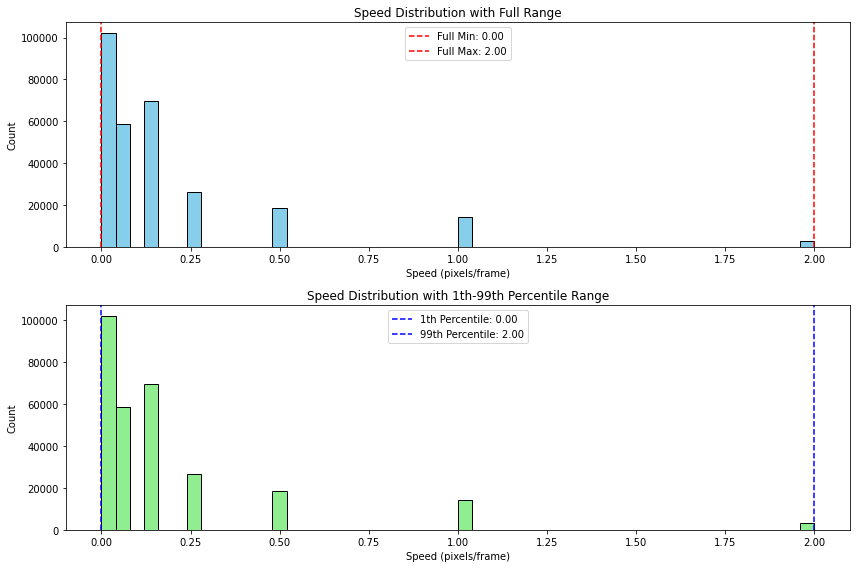

In [25]:
# Visualize the effect of outlier removal on speed distribution
plt.figure(figsize=(12, 8))

# Get the data without NaNs
speed_data = native_surface_map.data[~np.isnan(native_surface_map.data)]
# Additionally filter out infinites
speed_data = speed_data[np.isfinite(speed_data)]

# Compute min/max values safely
full_min = np.min(speed_data)
full_max = np.max(speed_data)

# Create histogram with original speed range
plt.subplot(2, 1, 1)
plt.hist(speed_data, bins=50, color='skyblue', edgecolor='black')
plt.axvline(x=full_min, color='red', linestyle='--', label=f'Full Min: {full_min:.2f}')
plt.axvline(x=full_max, color='red', linestyle='--', label=f'Full Max: {full_max:.2f}')
plt.title('Speed Distribution with Full Range')
plt.xlabel('Speed (pixels/frame)')
plt.ylabel('Count')
plt.legend()

# Create histogram with outlier-filtered speed range
lower_percentile = 1  # Exclude bottom 1%
upper_percentile = 99  # Exclude top 1%
min_speed = np.percentile(speed_data, lower_percentile)
max_speed = np.percentile(speed_data, upper_percentile)

plt.subplot(2, 1, 2)
plt.hist(speed_data, bins=50, color='lightgreen', edgecolor='black')
plt.axvline(x=min_speed, color='blue', linestyle='--', label=f'{lower_percentile}th Percentile: {min_speed:.2f}')
plt.axvline(x=max_speed, color='blue', linestyle='--', label=f'{upper_percentile}th Percentile: {max_speed:.2f}')
plt.title(f'Speed Distribution with {lower_percentile}th-{upper_percentile}th Percentile Range')
plt.xlabel('Speed (pixels/frame)')
plt.ylabel('Count')
plt.legend()

plt.tight_layout()
plt.savefig(save_path / f"speeds_distribution_comparison_sub{sub}.png")
plt.show()